In [165]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [166]:
# Specify directories 
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"

cpi = pd.read_csv(f"{data_dir}/CPI/CPIAUCSL.csv")
profit_share = pd.read_csv(f"{data_dir}/profits/profit_share.csv")

In [167]:
# dataset 
historical_data = pd.read_csv(f"{output_dir}/data/historical_data_feb.csv")
#historical_data['date'] = pd.to_datetime(data['date']) 


In [168]:
keep = ['date', 'U_rate']
u_rate = historical_data[keep]
u_rate['date'] = pd.to_datetime(u_rate['date'])

C:\Users\singhy\AppData\Local\Temp\ipykernel_11024\1026920671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_rate['date'] = pd.to_datetime(u_rate['date'])


In [169]:
u_rate['quarter_start'] = u_rate['date'].dt.to_period('Q').dt.start_time

# Group by the quarter start date and take mean
u_rate = u_rate.groupby('quarter_start').mean().reset_index()
u_rate = u_rate.drop(columns = ['date'])
u_rate = u_rate.rename(columns = {'quarter_start':'date'})

C:\Users\singhy\AppData\Local\Temp\ipykernel_11024\3193849559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_rate['quarter_start'] = u_rate['date'].dt.to_period('Q').dt.start_time


In [170]:

# CPI-U 
cpi = cpi.iloc[10:].reset_index(drop=True)

cpi = cpi.rename(columns={
                            'observation_date': 'date', 
                            'CPIAUCSL':               'P'
})

cpi['date'] = pd.to_datetime(cpi['date'])
cpi['P'] = pd.to_numeric(cpi['P'], errors='coerce')
cpi['P_12m_change'] = cpi['P'].pct_change(periods=12) * 100


In [171]:
cpi = cpi[cpi['date'] >= '1951-01-01']

In [172]:
cpi['quarter_start'] = cpi['date'].dt.to_period('Q').dt.start_time

# Group by the quarter start date and take mean
cpi = cpi.groupby('quarter_start').mean().reset_index()
cpi = cpi.drop(columns = ['date'])
cpi = cpi.rename(columns = {'quarter_start':'date'})

In [173]:
profit_share = profit_share.rename(columns={
                            'observation_date': 'date', 
                            'CP_GDP': 'profit_share'
})

profit_share['date'] = pd.to_datetime(profit_share['date'])
profit_share['profit_share'] = profit_share['profit_share']*100

In [178]:
profit_share.to_csv(f"{output_dir}/data/profit_share.csv", index = False)

In [174]:
data = profit_share.merge(cpi, on='date')
data = data.merge(u_rate, on='date')

In [175]:
data

,date,profit_share,P,P_12m_change,U_rate
0,1951-01-01,7.841,25.696667,8.944108,3.515552
1,1951-04-01,6.565,25.946667,9.174134,3.111350
2,1951-07-01,5.913,25.933333,7.149059,3.202318
3,1951-10-01,6.343,26.316667,6.577384,3.392458
4,1952-01-01,6.131,26.416667,2.810668,3.077104
...,...,...,...,...,...
291,2023-10-01,11.449,308.099000,3.236143,3.784906
292,2024-01-01,11.581,310.989667,3.248952,3.800707
293,2024-04-01,11.762,313.160333,3.194523,3.965136
294,2024-07-01,11.585,314.113667,2.640769,4.167878


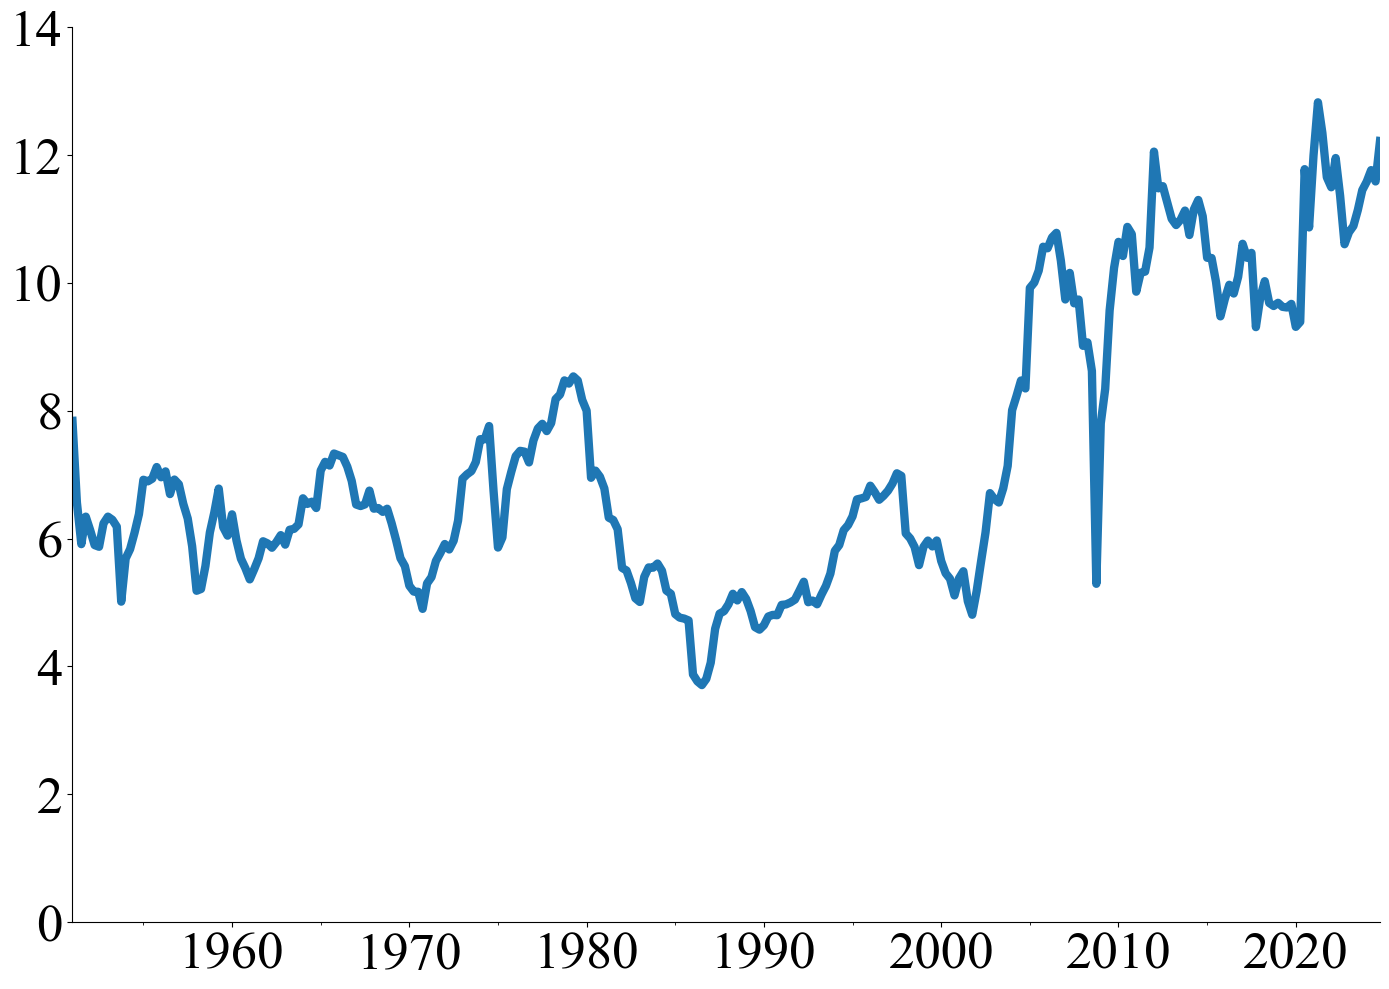

In [160]:
# Ensure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Plot
ax = data.plot(x='date', y='profit_share', figsize=(14, 10), legend=False, linewidth  = 6)
plt.ylim(0, 14)

# Clean up the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove x-axis label and set tick label size
ax.set_xlabel("")  # This removes the 'date' label
ax.tick_params(axis='both', labelsize=38)

plt.tight_layout()
plt.savefig(f"{output_dir}/figures/profit_share_timeseries.pdf", format='pdf')
plt.show()



In [122]:
import statsmodels.api as sm

# Filter data for historical regressions (pre-2000)
reg_data = data[(data['date'] >= '1951-01-01') & (data['date'] <= '1999-12-01')].copy()
reg_data['U_rate_squared'] = reg_data['U_rate'] ** 2

def run_regression(data, y_var, covariates):
    X = sm.add_constant(data[covariates])
    y = data[y_var]
    return sm.OLS(y, X).fit()

# LaTeX table header
latex_table = """\\begin{table}[!htbp]
\\centering
\\caption{Regression Results: Profit Share as Outcome}
\\label{tab:profit_share_regs}
\\begin{tabular}{lccc}
\\hline\\hline
& (1) & (2) & (3) \\\\
\\hline
"""

# Define regression specs
specs = [
    ['U_rate'],
    ['U_rate', 'P_12m_change'],
    ['U_rate', 'U_rate_squared', 'P_12m_change']
]

# Run regressions
models = [run_regression(reg_data, 'profit_share', covs) for covs in specs]

# Helper: format coefficient + stars
def format_coef(coef, pval):
    stars = ''
    if pval < 0.01:
        stars = '^{***}'
    elif pval < 0.05:
        stars = '^{**}'
    elif pval < 0.1:
        stars = '^{*}'
    return f"{coef:.3f}{stars}"

# Variable label mapping
var_labels = {
    'U_rate': 'Unemployment Rate',
    'P_12m_change': 'Inflation',
    'U_rate_squared': 'Unemployment Rate$^2$',
    'const': 'Constant'
}

# Add coefficients + standard errors
for var in ['U_rate', 'U_rate_squared', 'P_12m_change', 'const']:
    row = var_labels.get(var, var) + " & "
    for model in models:
        if var in model.params:
            coef = format_coef(model.params[var], model.pvalues[var])
            se = f"({model.bse[var]:.3f})"
            row += f"${coef}$ & "
        else:
            row += " & "
    row = row.rstrip(" & ") + " \\\\\n"

    # Add standard error row if variable exists in any model
    se_row = " & "
    for model in models:
        if var in model.params:
            se_row += f"({model.bse[var]:.3f}) & "
        else:
            se_row += " & "
    se_row = se_row.rstrip(" & ") + " \\\\\n"

    latex_table += row + se_row

# Add R-squared and sample size
latex_table += "\\hline\n"
r2_row = "R$^2$ & " + " & ".join(f"{m.rsquared:.3f}" for m in models) + " \\\\\n"
n_row = "Observations & " + " & ".join(str(int(m.nobs)) for m in models) + " \\\\\n"
latex_table += r2_row + n_row

# Footer
latex_table += """\\hline\\hline
\\multicolumn{4}{l}{\\textit{Note:} Standard errors in parentheses.} \\\\
\\multicolumn{4}{l}{*** p$<$0.01, ** p$<$0.05, * p$<$0.1} \\\\
\\end{tabular}
\\end{table}
"""

# Write LaTeX to file
with open(f"{output_dir}/tables/profit_share_regressions.tex", "w") as f:
    f.write(latex_table)


In [123]:
reg_data

,date,profit_share,P,P_12m_change,U_rate,U_rate_squared
0,1951-01-01,7.841,25.696667,8.944108,3.515552,12.359105
1,1951-04-01,6.565,25.946667,9.174134,3.111350,9.680498
2,1951-07-01,5.913,25.933333,7.149059,3.202318,10.254839
3,1951-10-01,6.343,26.316667,6.577384,3.392458,11.508770
4,1952-01-01,6.131,26.416667,2.810668,3.077104,9.468569
...,...,...,...,...,...,...
191,1998-10-01,5.585,164.133333,1.525740,4.433573,19.656570
192,1999-01-01,5.870,164.733333,1.687243,4.288388,18.390270
193,1999-04-01,5.969,165.966667,2.112586,4.252820,18.086481
194,1999-07-01,5.877,167.200000,2.346320,4.248134,18.046641


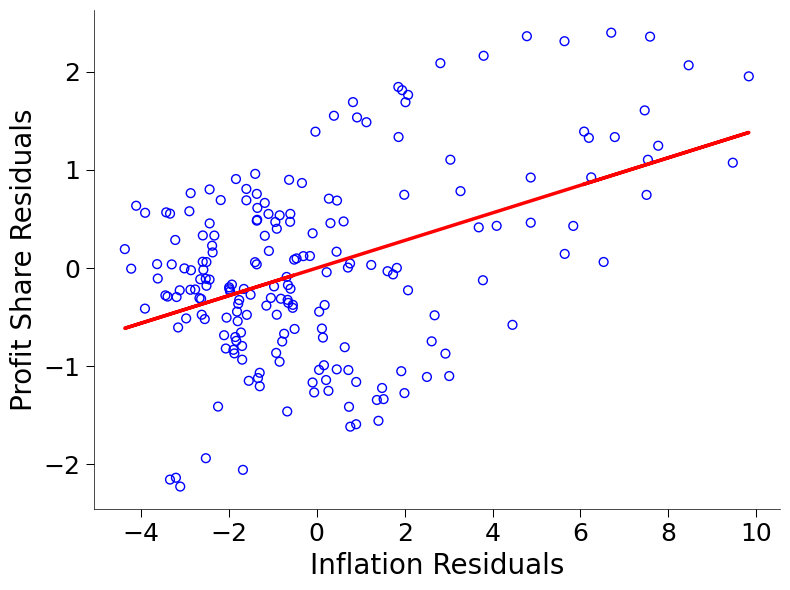

In [163]:
# Set figure style for AER
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))  # Slightly larger figure

# Create scatter plot with blue outlines and no fill
ax.scatter(reg_data['inflation_residuals'], 
           reg_data['profit_share_residuals'], 
           edgecolor='blue', 
           facecolor='none', 
           s=40)  # Slightly larger point size

# Fit and add regression line
x = reg_data['inflation_residuals']
y = reg_data['profit_share_residuals']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), color='red', linewidth=2.5)  # Thicker regression line

# Clean up plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Font and label styling
plt.rcParams['font.family'] = 'Times New Roman'
ax.set_xlabel('Inflation Residuals', fontsize=20)
ax.set_ylabel('Profit Share Residuals', fontsize=20)
ax.tick_params(direction='out', length=6, width=0.75, labelsize=18)

plt.tight_layout()
plt.savefig(f"{output_dir}/figures/profit_residuals_plot.pdf")
plt.show()


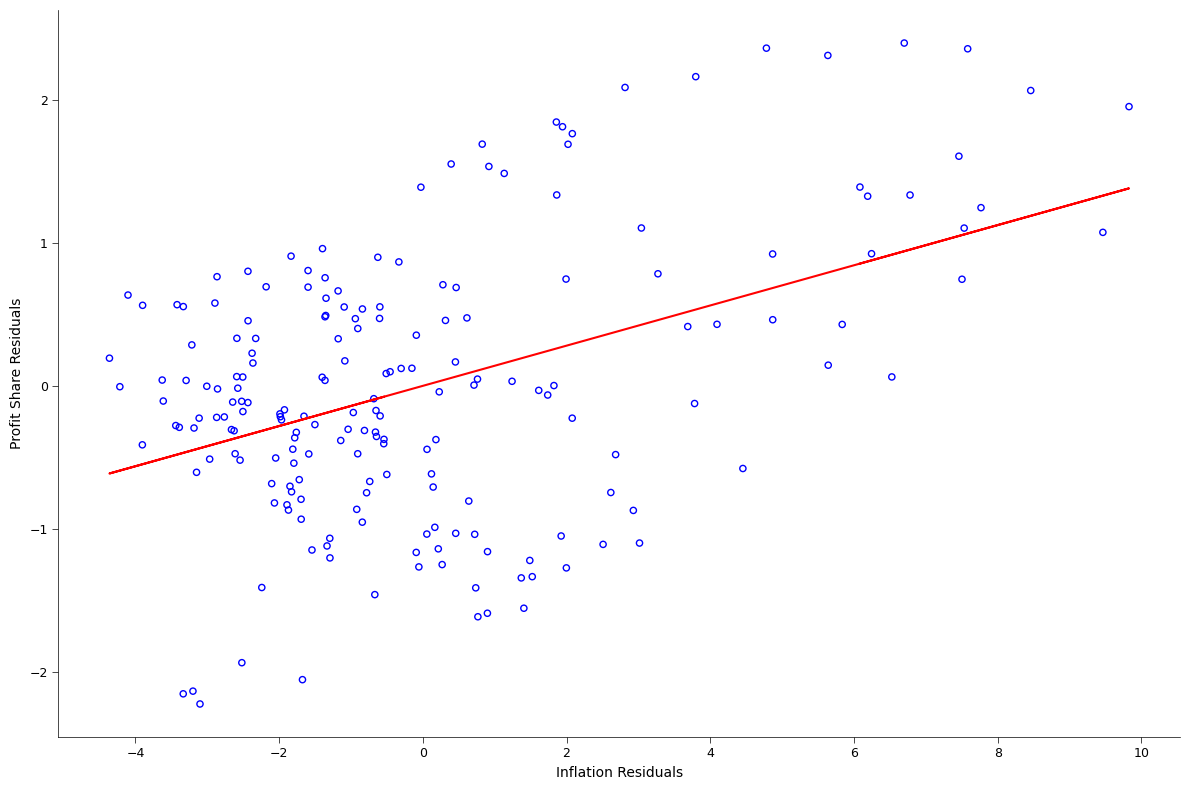

In [162]:
##########################################################
# Residual Anlysis 
##########################################################

# Prepare the data

# Residualizing Inflation 
X = sm.add_constant(reg_data[['U_rate', 'U_rate_squared']])  
y = reg_data['P_12m_change'] 

model = sm.OLS(y, X).fit()

# Get residuals and add them to your dataframe
reg_data['inflation_residuals'] = model.resid


# Residualizing Vacancy to Unemployment Rate 
X = sm.add_constant(reg_data[['U_rate', 'U_rate_squared']])  
y = reg_data['profit_share']  

# Fit the regression
model = sm.OLS(y, X).fit()

reg_data['profit_share_residuals'] = model.resid


### Make our figure ####
# Set figure style for AER
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12,8))  # AER typically uses smaller figures

# Create scatter plot with blue outlines and no fill
ax.scatter(reg_data['inflation_residuals'], 
           reg_data['profit_share_residuals'], 
           edgecolor='blue',  # Outline color
           facecolor='none',  # No fill color
           s=20)  # Smaller point size

# Calculate and add regression line in red
x = reg_data['inflation_residuals']
y = reg_data['profit_share_residuals']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), color='red', linewidth=1.5)  # Regression line in red

# Customize axes and labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Add labels with proper formatting
ax.set_xlabel('Inflation Residuals', fontsize=10)
ax.set_ylabel('Profit Share Residuals', fontsize=10)

# Remove grid
ax.grid(False)

# Set tick parameters
ax.tick_params(direction='out', length=4, width=0.5, labelsize=9)

# Adjust layout
plt.tight_layout()

# Optional: Save with high DPI for publication
plt.savefig(f"{output_dir}/figures/profit_residuals_plot.pdf")

plt.show()

In [91]:
data = data[(data['date'] >= '1950-01-01') & (data['date'] < '2000-01-01')]

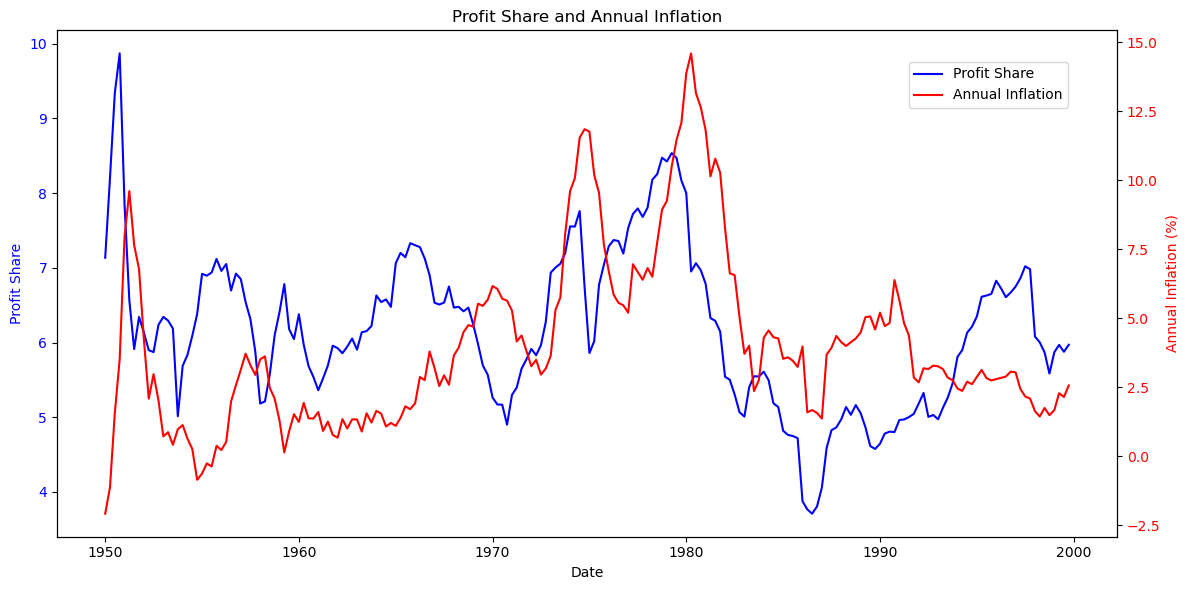

In [92]:
import matplotlib.pyplot as plt

# Create plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot profit_share (left axis)
ax1.plot(data['date'], data['profit_share'], 'b-', label='Profit Share')
ax1.set_xlabel('Date')
ax1.set_ylabel('Profit Share', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for P_12m_change
ax2 = ax1.twinx()  
ax2.plot(data['date'], data['P_12m_change'], 'r-', label='Annual Inflation')
ax2.set_ylabel('Annual Inflation (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
plt.title('Profit Share and Annual Inflation')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [93]:
data['log_profit_share'] = np.log(data['profit_share'])
data['log_P_12m_change'] = np.log(data['P_12m_change'])


C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [94]:
data

,date,profit_share,P,P_12m_change,log_profit_share,log_P_12m_change
8,1950-01-01,7.135,23.51,-2.082466,1.965012,NaN
9,1950-04-01,8.201,23.65,-1.128763,2.104256,NaN
10,1950-07-01,9.339,24.07,1.561181,2.234199,0.445443
11,1950-10-01,9.871,24.50,3.506548,2.289601,1.254632
12,1951-01-01,7.841,25.38,7.954062,2.059366,2.073683
...,...,...,...,...,...,...
203,1998-10-01,5.585,163.90,1.486068,1.720084,0.396134
204,1999-01-01,5.870,164.70,1.666667,1.769855,0.510826
205,1999-04-01,5.969,165.90,2.281134,1.786579,0.824673
206,1999-07-01,5.877,166.70,2.144608,1.771046,0.762957


In [95]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming your data is in a DataFrame called 'data'
# First ensure date is datetime and extract month
data['date'] = pd.to_datetime(data['date'])

data['month'] = data['date'].dt.month  # Extract month (1-12) for fixed effects

# Run regression: profit_share ~ P_12m_change + month fixed effects
model = smf.ols('profit_share ~ P_12m_change + C(month)', data=data).fit()

# Print full regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           profit_share   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.994
Date:                Wed, 02 Apr 2025   Prob (F-statistic):             0.0199
Time:                        10:27:06   Log-Likelihood:                -286.24
No. Observations:                 200   AIC:                             582.5
Df Residuals:                     195   BIC:                             599.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.8472      0.172     34.

In [96]:

# Run regression: profit_share ~ P_12m_change + month fixed effects
model = smf.ols('log_profit_share ~ log_P_12m_change + C(month)', data=data).fit()

# Print full regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       log_profit_share   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7649
Date:                Wed, 02 Apr 2025   Prob (F-statistic):              0.549
Time:                        10:27:06   Log-Likelihood:                 69.853
No. Observations:                 194   AIC:                            -129.7
Df Residuals:                     189   BIC:                            -113.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7688      0.030  

In [101]:
# Yash Singh 
# 11/22/24 
# this script takes data from Philly Fed and does some processing. This script will generate cleaned files that will be used to make plots. 

import pandas as pd

# Define directories
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"

# Load FMP data

#df = pd.read_excel(f"{data_dir}/FMP/ee_fmp.xlsx", sheet_name="Data")
df = pd.read_csv(f"{data_dir}/FMP/EE.csv") 

# Rename column
df.rename(columns={"FMPSA3MA": "ee_pol", 'observation_date': 'date'}, inplace=True)

# Create 'date_monthly' column
#df["date_monthly"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
df['date_monthly'] = pd.to_datetime(df['date'])

# Keep only relevant columns
df = df[["date_monthly", "ee_pol"]]


# save monthly data 
df.to_csv(f"{output_dir}/data/ee_monthly.csv", index = False )

In [100]:
df

,date_monthly,ee_pol
0,1995-12-01,2.867969
1,1996-01-01,2.847177
2,1996-02-01,2.776150
3,1996-03-01,2.818454
4,1996-04-01,2.833908
...,...,...
346,2024-10-01,2.400130
347,2024-11-01,2.236716
348,2024-12-01,2.240904
349,2025-01-01,2.149208
